In [485]:
# !pip install imblearn

import pandas as pd
import matplotlib.pyplot as plt
import numpy 
from scipy.stats import zscore
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

importing the dataset using pandas


In [412]:
training_data = pd.read_csv("C:/ML-CW/adult/adult.data",na_values=' ')
testing_data =pd.read_csv("C:/ML-CW/adult/adult.test",na_values=' ',delimiter=",")

Adding headers to the coloumns and displaying the dataFrame

In [413]:
training_data.columns =["age","employement","final-weight","education","education-num","marital-status","occupation","relationship"
               ,"race","sex","capital-gain","capital-loss", "hrs-per-week","country","salary-limit"]


print("training data")
print(training_data.head(5))
print(" ")
print("total rows:",len(training_data))



training data
   age        employement  final-weight   education  education-num  \
0   50   Self-emp-not-inc         83311   Bachelors             13   
1   38            Private        215646     HS-grad              9   
2   53            Private        234721        11th              7   
3   28            Private        338409   Bachelors             13   
4   37            Private        284582     Masters             14   

        marital-status          occupation    relationship    race      sex  \
0   Married-civ-spouse     Exec-managerial         Husband   White     Male   
1             Divorced   Handlers-cleaners   Not-in-family   White     Male   
2   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
3   Married-civ-spouse      Prof-specialty            Wife   Black   Female   
4   Married-civ-spouse     Exec-managerial            Wife   White   Female   

   capital-gain  capital-loss  hrs-per-week         country salary-limit  
0             0

In [414]:
testing_data.columns =["age","employement","final-weight","education","education-num","marital-status","occupation","relationship"
               ,"race","sex","capital-gain","capital-loss", "hrs-per-week","country","salary-limit"]
print("testing data")
print(testing_data.head(5))

testing data
   age employement  final-weight      education  education-num  \
0   38     Private         89814        HS-grad              9   
1   28   Local-gov        336951     Assoc-acdm             12   
2   44     Private        160323   Some-college             10   
3   18           ?        103497   Some-college             10   
4   34     Private        198693           10th              6   

        marital-status          occupation    relationship    race      sex  \
0   Married-civ-spouse     Farming-fishing         Husband   White     Male   
1   Married-civ-spouse     Protective-serv         Husband   White     Male   
2   Married-civ-spouse   Machine-op-inspct         Husband   Black     Male   
3        Never-married                   ?       Own-child   White   Female   
4        Never-married       Other-service   Not-in-family   White     Male   

   capital-gain  capital-loss  hrs-per-week         country salary-limit  
0             0             0           

as per the documentation only three columns include null values we are going to explore different models with different ways of dealing with those null values.
First of all lets prepare the testing dataset since we will only get the rows with complete data

In [415]:
length_before = len(testing_data)
testing_data = testing_data[testing_data.employement!=" ?"]
testing_data = testing_data[testing_data.country !=" ?"]
testing_data = testing_data[testing_data.occupation !=" ?"]

length_after = len(testing_data)

print("lost rows : "+str((length_before-length_after)))

lost rows : 1221


and as the above result shows there were no empty rows so the testing dataset is prepared. next define the methods to normalize the data 

In [416]:
ordinal_enc = OrdinalEncoder()
scaler = StandardScaler()

def normalize(data):
    data['employement'] = ordinal_enc.fit_transform(data[['employement']])
    data['education'] = ordinal_enc.fit_transform(data[['education']])
    data['marital-status'] = ordinal_enc.fit_transform(data[['marital-status']])
    data['occupation'] = ordinal_enc.fit_transform(data[['occupation']])
    data['relationship'] = ordinal_enc.fit_transform(data[['relationship']])
    data['race'] = ordinal_enc.fit_transform(data[['race']])
    data['sex'] = ordinal_enc.fit_transform(data[['sex']])
    data['country'] = ordinal_enc.fit_transform(data[['country']])
    data['relationship'] = ordinal_enc.fit_transform(data[['relationship']])
    data['salary-limit'] = ordinal_enc.fit_transform(data[['salary-limit']])

    data =   pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    data.loc[data['salary-limit']<0,'salary-limit']=0#re-adjusting the salary limit coloumn for randomForest
    data.loc[data['salary-limit']>0,'salary-limit']=1

    return data



creating test data and test labels

In [417]:
test_data_normalized = normalize(testing_data)

X_test =test_data_normalized.drop('salary-limit' ,axis=1)
y_test = test_data_normalized['salary-limit']

print(X_test.head(5))
print("____________")
print(y_test.head(5))


        age  employement  final-weight  education  education-num  \
0 -0.057491    -0.222355     -0.944944   0.190042      -0.434986   
1 -0.804864    -1.257101      1.395045  -0.855572       0.737530   
2  0.390933    -0.222355     -0.277338   1.235656      -0.044147   
3 -0.356440    -0.222355      0.085964  -2.685395      -1.607502   
4  1.810941     1.847139     -0.804699   0.974252       1.910045   

   marital-status  occupation  relationship      race       sex  capital-gain  \
0       -0.395400   -0.494773     -0.881923  0.382135  0.695867     -0.145443   
1       -0.395400    0.997722     -0.881923  0.382135  0.695867     -0.145443   
2       -0.395400    0.002726     -0.881923 -2.034736  0.695867      0.852586   
3        0.933245    0.251475     -0.252557  0.382135  0.695867     -0.145443   
4       -0.395400    0.748973     -0.881923  0.382135  0.695867      0.257377   

   capital-loss  hrs-per-week  country  
0     -0.219177      0.750101  0.26059  
1     -0.219177     -0

next we will prepare the dataset with null rows removed

In [418]:
before_length = len(training_data)

without_null_values =training_data[training_data.employement!=" ?"]
without_null_values = without_null_values[without_null_values.country !=" ?"]
without_null_values = without_null_values[without_null_values.occupation !=" ?"]
after_length = len(without_null_values)

print("loss percentage :"+str((before_length-after_length)*100/before_length))





loss percentage :7.367936117936118


so we have lost roughly 7% of rows available, we will continue and see how the accuracy  it is is
First preparing the dataset for training(normalization,labels)

Statistics of the dataset

In [419]:
without_null_values.describe()

,age,final-weight,education-num,capital-gain,capital-loss,hrs-per-week
count,30161.000000,3.016100e+04,30161.000000,30161.000000,30161.000000,30161.000000
mean,38.437883,1.897976e+05,10.121216,1091.971984,88.375419,40.931269
std,13.134882,1.056527e+05,2.549983,7406.466659,404.304753,11.980182
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176280e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784290e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376300e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [420]:
without_null_values.describe(include='object')

,employement,education,marital-status,occupation,relationship,race,sex,country,salary-limit
count,30161,30161,30161,30161,30161,30161,30161,30161,30161
unique,7,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22286,9840,14065,4038,12463,25932,20379,27503,22653


<Axes: >

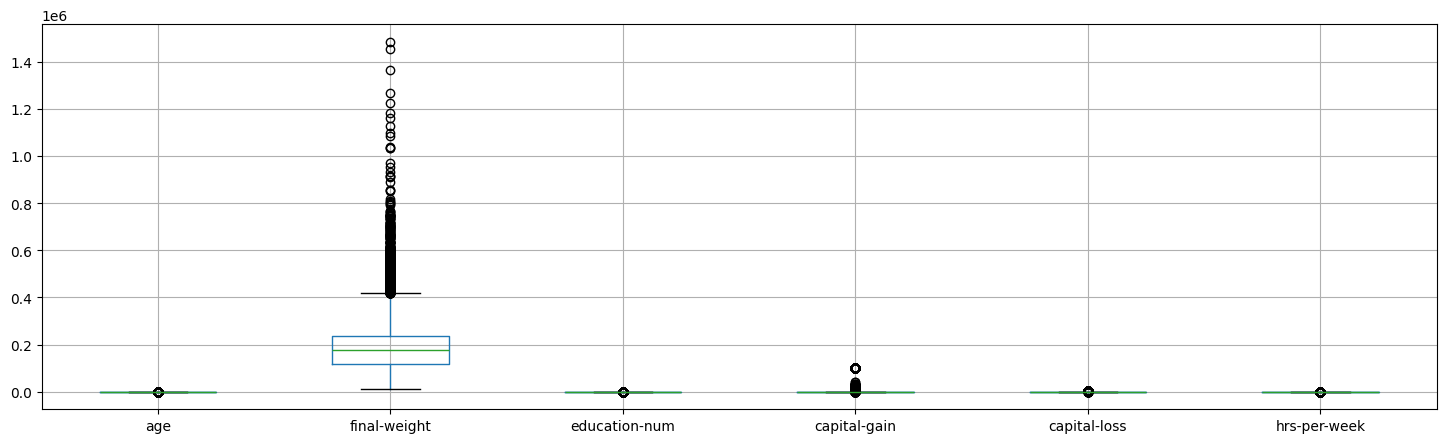

In [421]:
without_null_values.boxplot(figsize=(18,5))

<Axes: title={'center': 'age'}, xlabel='salary-limit'>

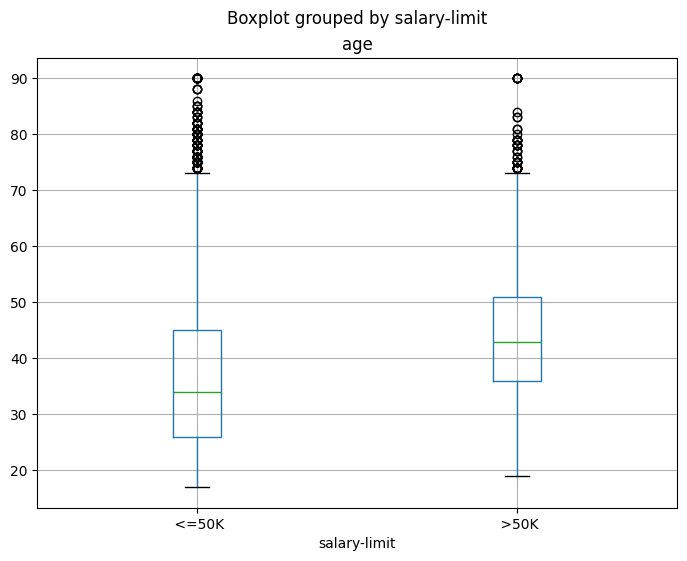

In [422]:
without_null_values.boxplot(column=['age'], by='salary-limit', figsize=(8, 6))

<Axes: title={'center': 'final-weight'}, xlabel='salary-limit'>

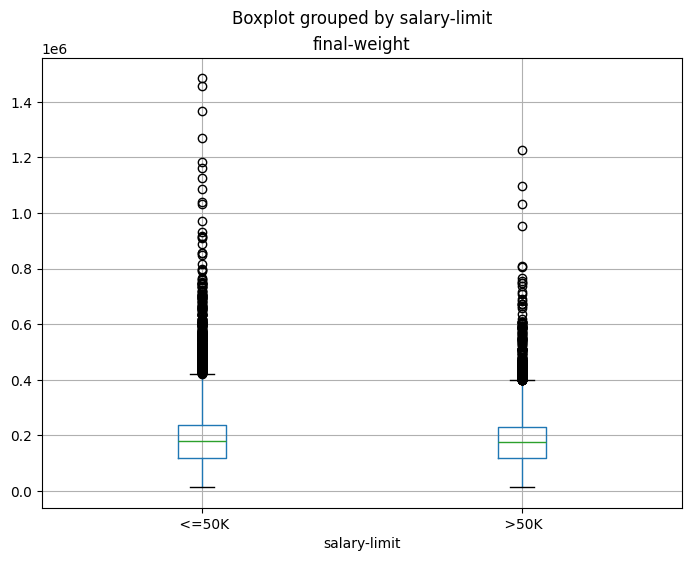

In [423]:
without_null_values.boxplot(column=['final-weight'], by='salary-limit', figsize=(8, 6))

<Axes: title={'center': 'education-num'}, xlabel='salary-limit'>

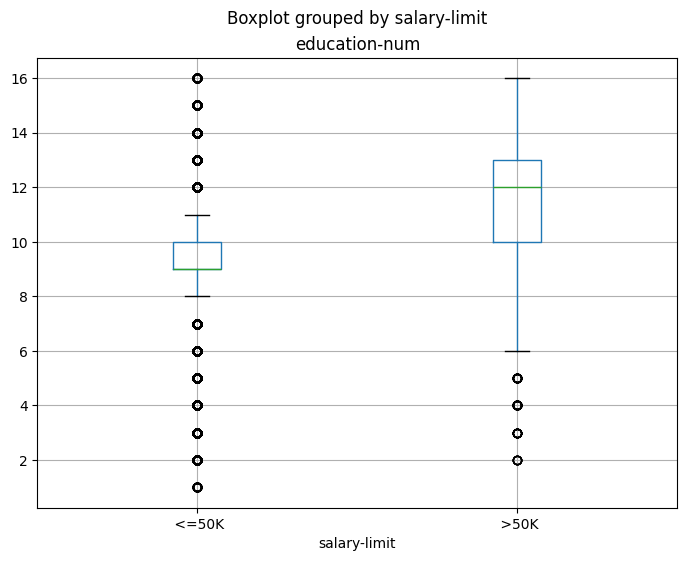

In [424]:
without_null_values.boxplot(column=['education-num'], by='salary-limit', figsize=(8, 6))

<Axes: title={'center': 'capital-gain'}, xlabel='salary-limit'>

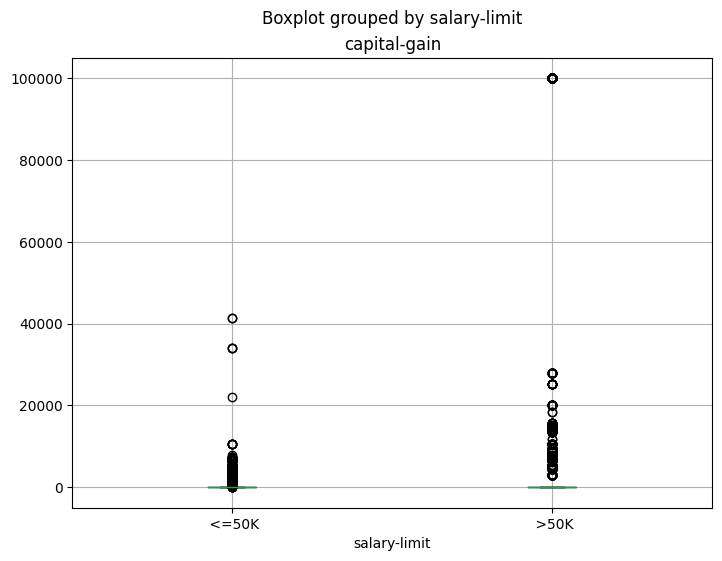

In [425]:
without_null_values.boxplot(column=['capital-gain'], by='salary-limit', figsize=(8, 6))

<Axes: title={'center': 'capital-loss'}, xlabel='salary-limit'>

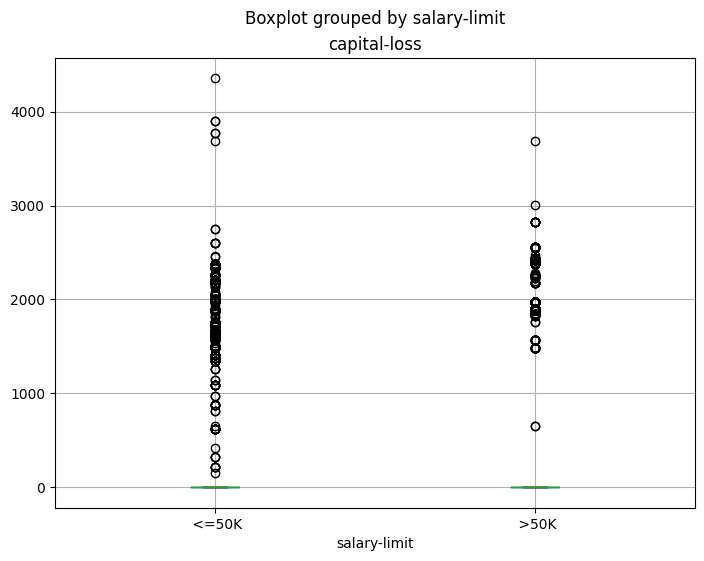

In [426]:
without_null_values.boxplot(column=['capital-loss'], by='salary-limit', figsize=(8, 6))

<Axes: title={'center': 'hrs-per-week'}, xlabel='salary-limit'>

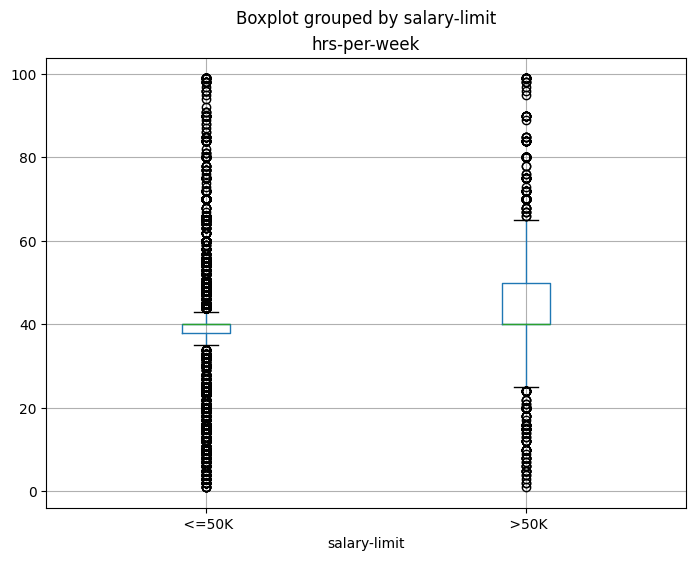

In [427]:
without_null_values.boxplot(column=['hrs-per-week'], by='salary-limit', figsize=(8, 6))

standard deviation and mean before standard scaler

In [428]:
numerical_features = without_null_values.select_dtypes(include=['int', 'float']).columns
standard_deviation = without_null_values[numerical_features].std()
print("Standard deviation for numerical columns:")
print(standard_deviation)

Standard deviation for numerical columns:
age                  13.134882
final-weight     105652.744919
education-num         2.549983
capital-gain       7406.466659
capital-loss        404.304753
hrs-per-week         11.980182
dtype: float64


Text(0.5, 1.0, 'Standard Deviation of Numerical Columns')

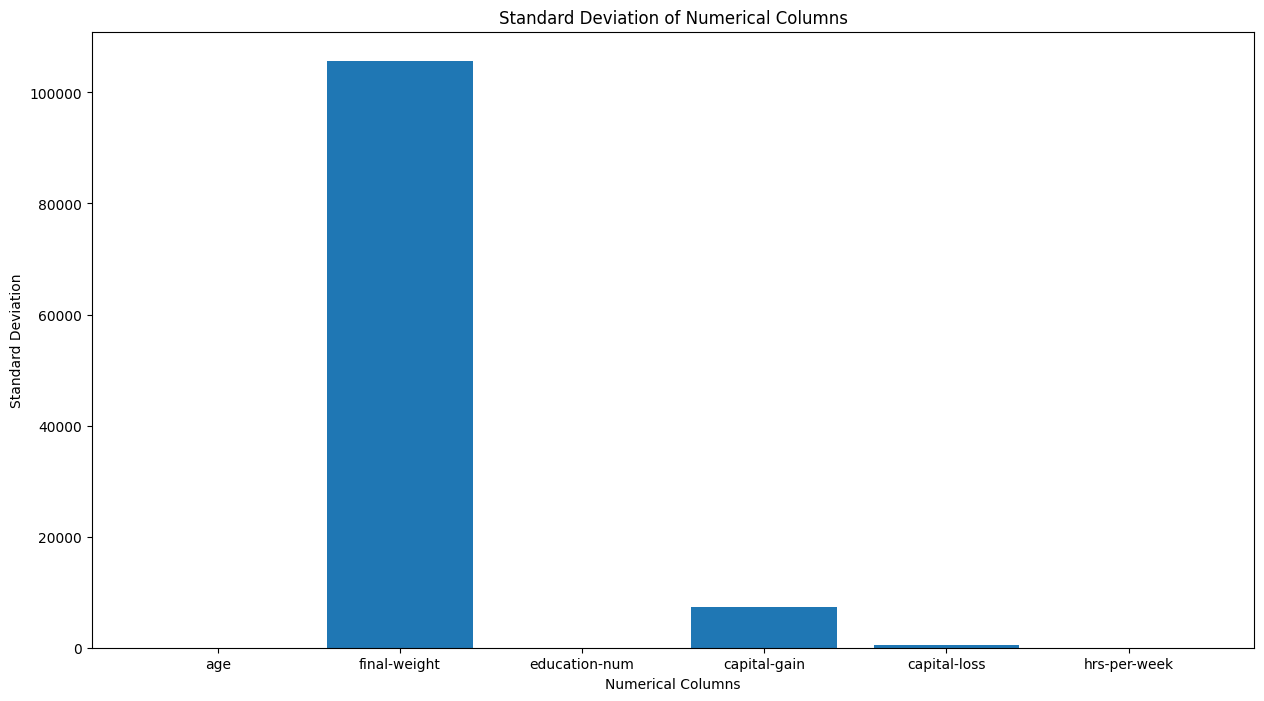

In [429]:
plt.figure(figsize=(15,8))
plt.bar(standard_deviation.index, standard_deviation.values)


# Add labels and title
plt.xlabel('Numerical Columns')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Numerical Columns')

In [430]:
means = without_null_values[numerical_features].mean()
print("mean of the numerical features")
print(means)

mean of the numerical features
age                  38.437883
final-weight     189797.556547
education-num        10.121216
capital-gain       1091.971984
capital-loss         88.375419
hrs-per-week         40.931269
dtype: float64


Text(0.5, 1.0, 'mean of Numerical Columns')

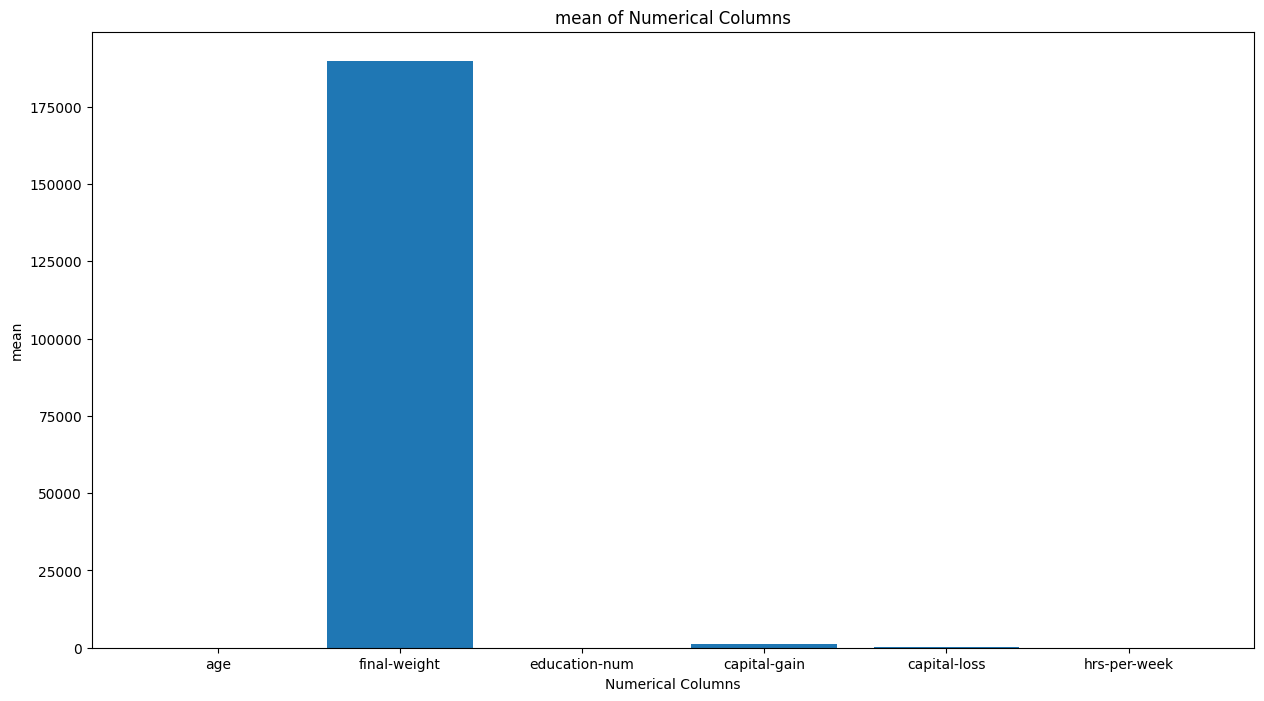

In [431]:
plt.figure(figsize=(15,8))
plt.bar(means.index, means.values)


# Add labels and title
plt.xlabel('Numerical Columns')
plt.ylabel('mean')
plt.title('mean of Numerical Columns')

Standandard deviation and mean after standard scaling 


Standard deviation for numerical columns:
age              1.000017
final-weight     1.000017
education-num    1.000017
capital-gain     1.000017
capital-loss     1.000017
hrs-per-week     1.000017
dtype: float64


Text(0.5, 1.0, 'Standard Deviation of Numerical Columns')

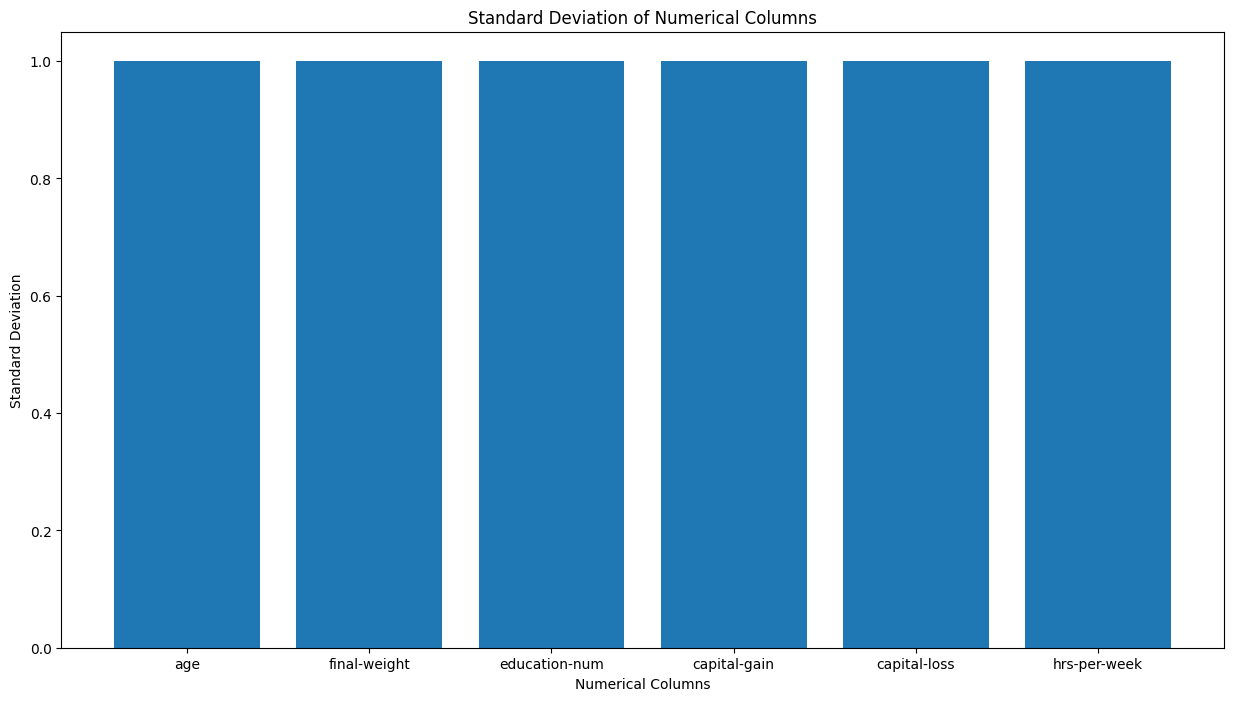

In [432]:
without_null_values= normalize(without_null_values)


standard_deviation = without_null_values[numerical_features].std()
print("Standard deviation for numerical columns:")
print(standard_deviation)
plt.figure(figsize=(15,8))
plt.bar(standard_deviation.index, standard_deviation.values)



plt.xlabel('Numerical Columns')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Numerical Columns')


mean of the numerical features
age              1.116665e-16
final-weight     5.936699e-17
education-num   -9.234865e-17
capital-gain    -1.083683e-17
capital-loss     3.887124e-17
hrs-per-week     1.646727e-16
dtype: float64


Text(0.5, 1.0, 'mean of Numerical Columns')

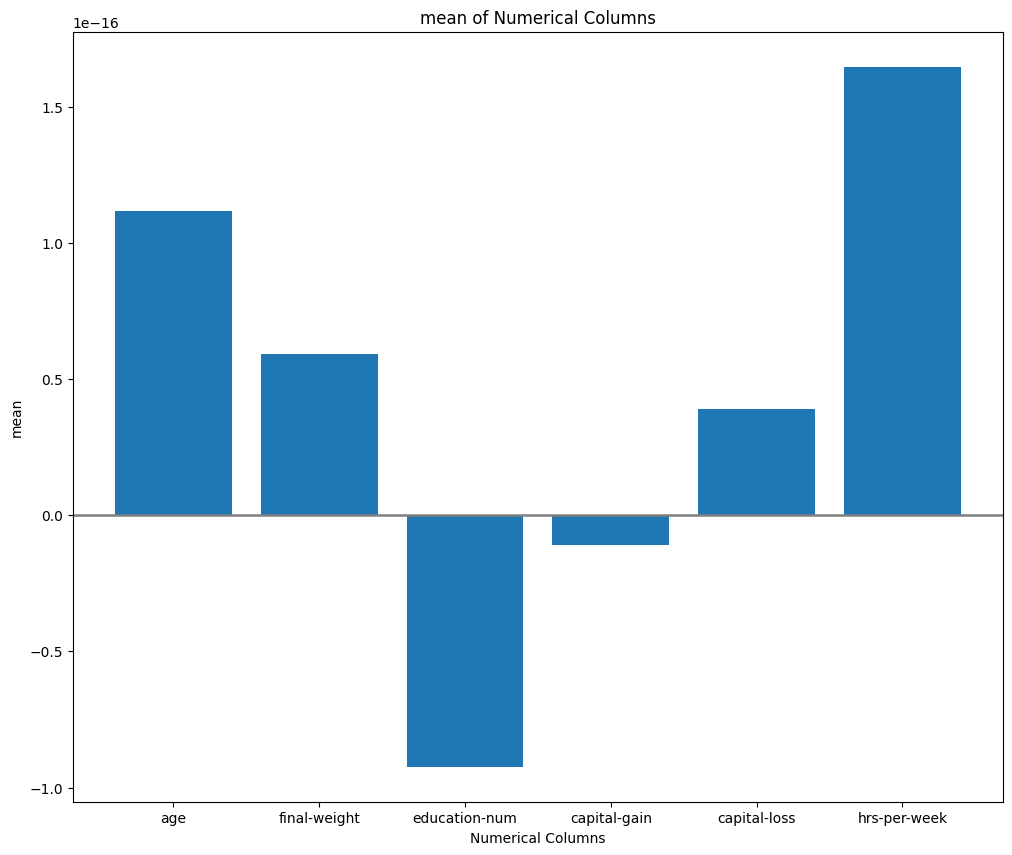

In [452]:
means = without_null_values[numerical_features].mean()
print("mean of the numerical features")
print(means)

plt.figure(figsize=(12,10))
plt.bar(means.index, means.values)

plt.axhline(0, color='gray', linewidth=1.8)
# Add labels and title
plt.xlabel('Numerical Columns')
plt.ylabel('mean')
plt.title('mean of Numerical Columns')

correlation matrix

<Axes: >

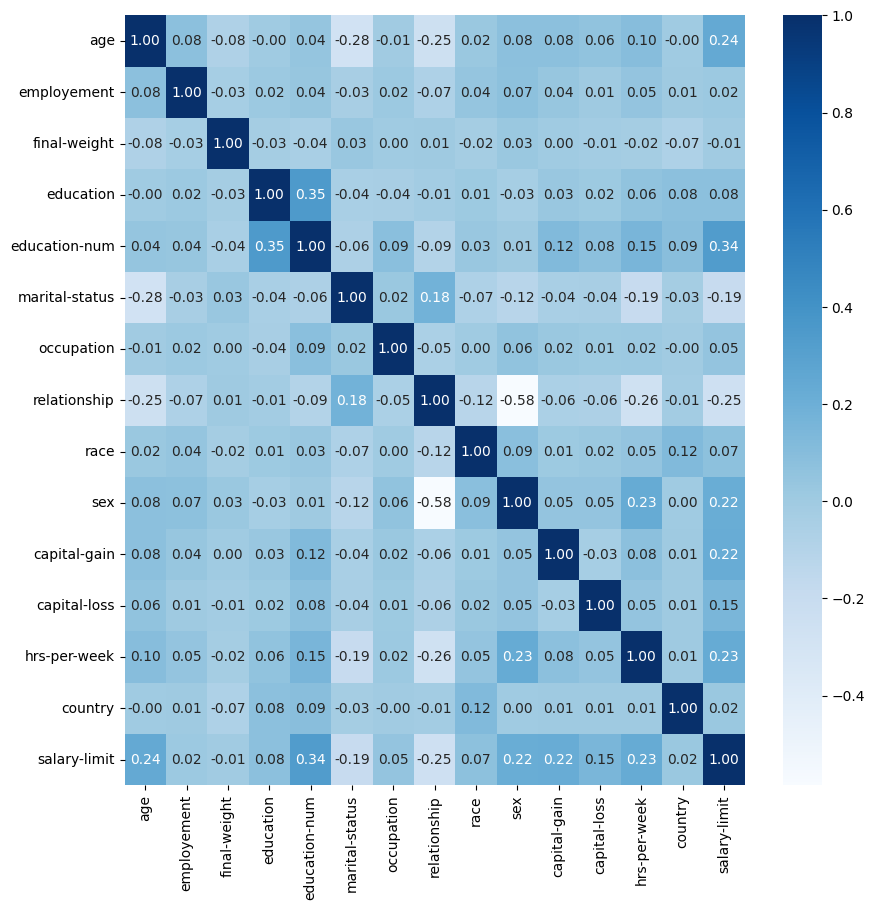

In [492]:
correlation_matrix = without_null_values.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")

In [434]:
X_train_wnl= without_null_values.drop('salary-limit' ,axis=1)#wnl=without_null_values
y_train_wnl=without_null_values['salary-limit']

using oversampling to balance the dataset

In [435]:
smote = SMOTE(random_state=11)
X_train_wnl_resampled ,y_train_wnl_resampled = smote.fit_resample(X_train_wnl,y_train_wnl)


random forest classifier without oversampling (standard dataset)

In [464]:
#without the oversampling
classifier_rfc_wnl = RandomForestClassifier(n_estimators=120)
classifier_rfc_wnl.fit(X_train_wnl,y_train_wnl)
prediction = classifier_rfc_wnl.predict(X_test)
print("Accuracy : ",accuracy_score(y_test, prediction))



Accuracy :  0.8466697655886845


In [465]:
classification= classification_report(y_test,prediction)
print(classification)

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90     11359
         1.0       0.72      0.61      0.66      3700

    accuracy                           0.85     15059
   macro avg       0.80      0.77      0.78     15059
weighted avg       0.84      0.85      0.84     15059



<Axes: >

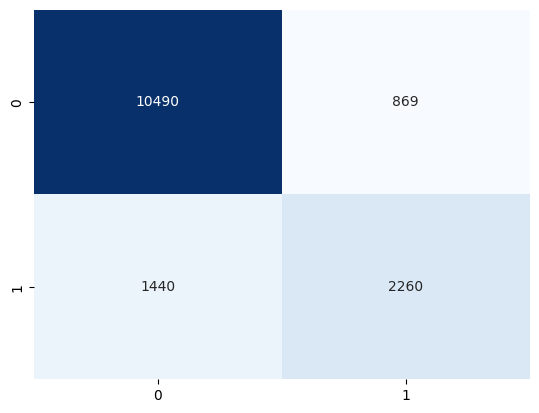

In [486]:
#confusion matrix 
conf_matrix = confusion_matrix(y_test, prediction)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

for random forest classifier with over sampling 

In [454]:
classifier_rfc_wnl_1 = RandomForestClassifier(n_estimators=120)
classifier_rfc_wnl_1.fit(X_train_wnl_resampled,y_train_wnl_resampled)

RandomForestClassifier(n_estimators=120)

In [469]:
#accuracy
prediction_1 = classifier_rfc_wnl_1.predict(X_test)
print("Accuracy : ",accuracy_score(y_test, prediction_1))

Accuracy :  0.7421475529583638


In [470]:
classification= classification_report(y_test,prediction_1)
print(classification)

              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     11359
         1.0       0.49      0.91      0.63      3700

    accuracy                           0.74     15059
   macro avg       0.72      0.80      0.72     15059
weighted avg       0.84      0.74      0.76     15059



and as you can see oversampling will lead to a decrease in accuracy

naive-bayes classifier with the standard dataset 

In [439]:
classifier_gnb_wnl = GaussianNB()
classifier_gnb_wnl.fit(X_train_wnl, y_train_wnl)

#accuracy of the model
y_pred = classifier_gnb_wnl.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7988578258848529


In [467]:
classification= classification_report(y_test,y_pred)
print(classification)

              precision    recall  f1-score   support

         0.0       0.81      0.95      0.88     11359
         1.0       0.68      0.34      0.45      3700

    accuracy                           0.80     15059
   macro avg       0.75      0.64      0.66     15059
weighted avg       0.78      0.80      0.77     15059



naive bayes with over sampling

In [473]:
classifier_gnb_wnl_1 = GaussianNB()
classifier_gnb_wnl_1.fit(X_train_wnl_resampled, y_train_wnl_resampled)

#accuracy of the model
y_pred_1 = classifier_gnb_wnl_1.predict(X_test)
accuracy_1 = accuracy_score(y_test, y_pred_1)
print("Accuracy:", accuracy_1)

Accuracy: 0.8143967062885982


In [474]:
classification= classification_report(y_test,y_pred_1)
print(classification)

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88     11359
         1.0       0.67      0.48      0.56      3700

    accuracy                           0.81     15059
   macro avg       0.76      0.70      0.72     15059
weighted avg       0.80      0.81      0.80     15059



<Axes: >

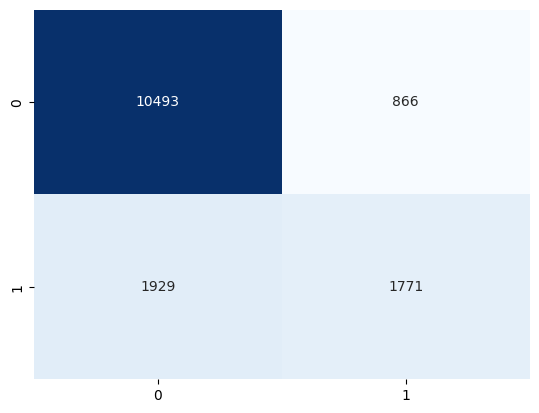

In [487]:
conf_matrix = confusion_matrix(y_test, y_pred_1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

removing outliers 

lets see whether there any oultiers in the coloumns age and hrs-per-week

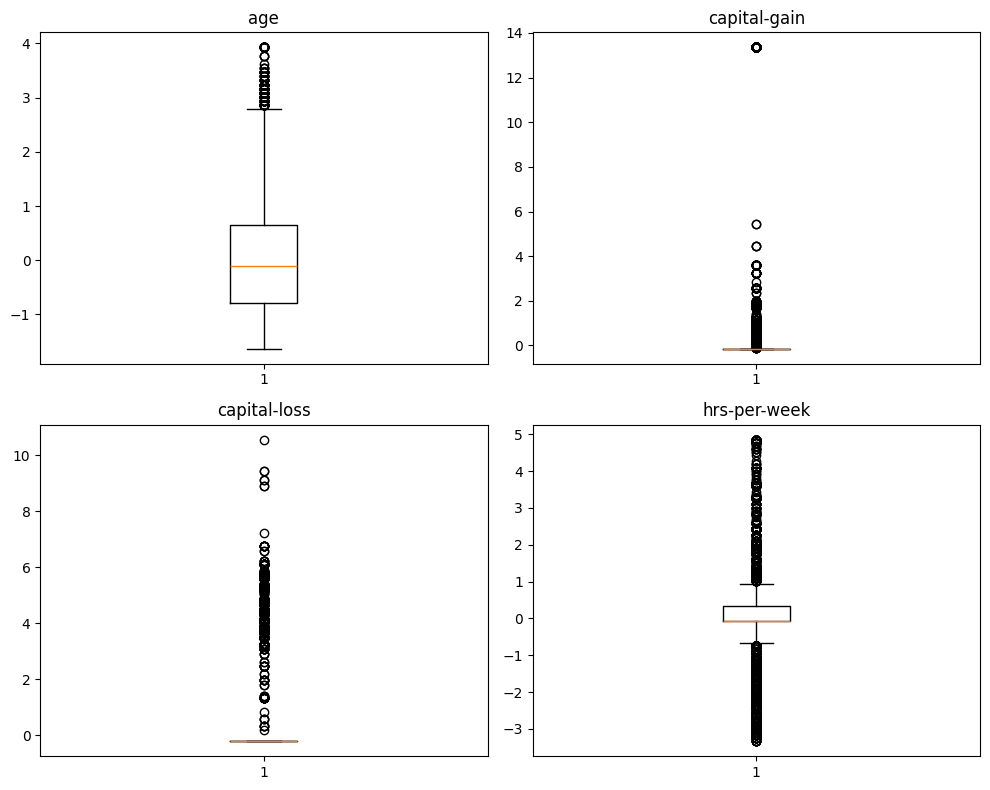

In [440]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot boxplots in each subplot
axs[0, 0].boxplot(without_null_values['age'])
axs[0, 0].set_title('age')

axs[0, 1].boxplot(without_null_values['capital-gain'])
axs[0, 1].set_title('capital-gain')

axs[1, 0].boxplot(without_null_values['capital-loss'])
axs[1, 0].set_title('capital-loss')

axs[1, 1].boxplot(without_null_values['hrs-per-week'])
axs[1, 1].set_title('hrs-per-week')

# Adjust layout
plt.tight_layout()

In [441]:
#filtering the extremes
without_outliers=without_null_values[(numpy.abs(zscore(without_null_values['age'])) < 3)]

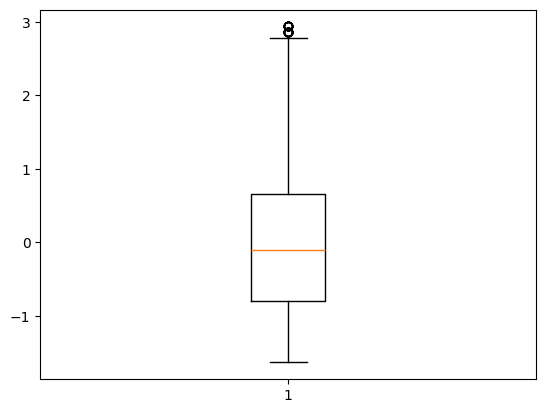

In [442]:
plt.boxplot(without_outliers['age'])
plt.show()

In [475]:
#testing the RFC accuracy
X_train_zscore= without_outliers.drop('salary-limit' ,axis=1)
y_train_zscore=without_outliers['salary-limit']
#training
classifier_rfc_zscore = RandomForestClassifier()
classifier_rfc_zscore.fit(X_train_zscore,y_train_zscore)
prediction_2 = classifier_rfc_zscore.predict(X_test)
print("Accuracy : ",accuracy_score(y_test, prediction_2))

Accuracy :  0.8489275516302544


In [476]:
classification= classification_report(y_test,prediction_2)
print(classification)

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     11359
         1.0       0.73      0.61      0.67      3700

    accuracy                           0.85     15059
   macro avg       0.80      0.77      0.78     15059
weighted avg       0.84      0.85      0.84     15059



In [477]:
#testing GNB accuracy
classifier_gnb_wnl = GaussianNB()
classifier_gnb_wnl.fit(X_train_zscore, y_train_zscore)

#accuracy of the model
y_pred_2 = classifier_gnb_wnl.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_2)
print("Accuracy:", accuracy)

Accuracy: 0.7997875024902051


In [478]:
classification= classification_report(y_test,y_pred_2)
print(classification)

              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88     11359
         1.0       0.68      0.34      0.46      3700

    accuracy                           0.80     15059
   macro avg       0.75      0.65      0.67     15059
weighted avg       0.78      0.80      0.77     15059



In [444]:
#for hrs-per-week
without_outliers=without_null_values[(numpy.abs(zscore(without_null_values['hrs-per-week'])) < 3)]
X_train_zscore= without_outliers.drop('salary-limit' ,axis=1)#wnl=without_null_values
y_train_zscore=without_outliers['salary-limit']
#training
classifier_rfc_zscore = RandomForestClassifier()
classifier_rfc_zscore.fit(X_train_zscore,y_train_zscore)
prediction = classifier_rfc_zscore.predict(X_test)
print("Accuracy : ",accuracy_score(y_test, prediction))

Accuracy :  0.8467361710604954


In [457]:
#testing GNB accuracy
classifier_gnb_wnl = GaussianNB()
classifier_gnb_wnl.fit(X_train_zscore, y_train_zscore)

#accuracy of the model
y_pred = classifier_gnb_wnl.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7997875024902051


after running and testing the model few times the accuracy shows that the change to the accuracy is very small and thus can be discarded

next we will consider a dataset with the missing values filled with the mode of the column

In [459]:

filled_with_mode = pd.read_csv("C:/ML-CW/adult/adult.data",na_values=' ?')
filled_with_mode.columns =["age","employement","final-weight","education","education-num","marital-status","occupation","relationship"
               ,"race","sex","capital-gain","capital-loss", "hrs-per-week","country","salary-limit"]

filled_with_mode['employement'].fillna(filled_with_mode['employement'].mode()[0], inplace=True)
filled_with_mode['country'].fillna(filled_with_mode['country'].mode()[0], inplace=True)
filled_with_mode['occupation'].fillna(filled_with_mode['occupation'].mode()[0], inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22048\693123103.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filled_with_mode['employement'].fillna(filled_with_mode['employement'].mode()[0], inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22048\693123103.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

after creating the dataset we will normalize it prepare for training the model

In [446]:
filled_with_mode= normalize(filled_with_mode)
X_train_fwm= without_null_values.drop('salary-limit' ,axis=1)#fwm = filled_with_mode
y_train_fwm=without_null_values['salary-limit']

training the Random Forest Model

In [447]:
classifier_rfc_fwm = RandomForestClassifier(n_estimators=110)
classifier_rfc_fwm.fit(X_train_fwm,y_train_fwm)

RandomForestClassifier(n_estimators=110)

In [479]:
#accuracy
prediction_3 = classifier_rfc_fwm.predict(X_test)
print("Accuracy : ",accuracy_score(y_test, prediction_3))


Accuracy :  0.8457400889833322


In [480]:
classification= classification_report(y_test,prediction_3)
print(classification)

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90     11359
         1.0       0.72      0.61      0.66      3700

    accuracy                           0.85     15059
   macro avg       0.80      0.77      0.78     15059
weighted avg       0.84      0.85      0.84     15059



Gaussian naive bayes

In [483]:
classifier_gnb_fwm = GaussianNB()
classifier_gnb_fwm.fit(X_train_fwm, y_train_fwm)

#accuracy of the model
y_pred_3 = classifier_gnb_fwm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_3)
print("Accuracy:", accuracy)

Accuracy: 0.7988578258848529


In [484]:
classification= classification_report(y_test,y_pred_3)
print(classification)

              precision    recall  f1-score   support

         0.0       0.81      0.95      0.88     11359
         1.0       0.68      0.34      0.45      3700

    accuracy                           0.80     15059
   macro avg       0.75      0.64      0.66     15059
weighted avg       0.78      0.80      0.77     15059

